# Frisch-Waugh-Lovell Theorem: example

This is a basic practical example of the Frisch-Waugh-Lovell (FWL) Theorem, and it was obtained from here: (https://towardsdatascience.com/the-fwl-theorem-or-how-to-make-all-regressions-intuitive-59f801eb3299).

In [1]:
import numpy as np
import pandas as pd
import random
import statsmodels.formula.api as smf #for using comprehensive OLS regressions
import matplotlib.pyplot as plt
import seaborn as sns #for plotting lin regressions

In [2]:
#DGP

np.random.seed(24)

#lower=0, upper=10 (doesn't include 10), all values equiprobable
df = pd.DataFrame({'x1': np.random.uniform(0, 10, size=50)})

#part of x2 is positively related to x1 (81.5%), part is fixed (3.4), 
#and part follows a normal w/ avg=0, std=1.35 (size=50 to give us 50 entries)
df['x2'] = 3.4 + df['x1'] * 0.815 + 4.073 * np.random.normal(0, 1.35, size=50)

#part of y is constant (9.298), part depends negatively on x1, part depends positvely on x2
#and part follows a normal w/ avg=0, std=1.65 (size=50 to give us 50 entries)
df['y'] = 9.298 - 1.57 * df['x1'] + 3.35 * df['x2'] + np.random.normal(0, 1.65, size=50)

In [3]:
df.head()

,x1,x2,y
0,9.600173,7.999032,19.876646
1,6.995120,10.699562,34.078605
2,9.998673,18.499654,54.617571
3,2.200673,6.788319,30.021138
4,3.610564,-4.491121,-13.016867


First, we estimate our model with the classical OLS and check the results.

In [4]:
model = smf.ols('y ~ x1 + x2', df).fit()
model.summary().tables[1]
#model.summary2()

#Prob (F-statistic): 1.78e-49, really close to zero, thus the model's variables are jointly significant (reject H_0 which states that they're jointly insignificant)
#t: precision of the coef estimate. A low std err compared to a high coef produces a high t statistic, meaning a high significance to your coef
#P>|t|: all of them real close to zero, thus all variables in the model are individually significant at .05 (usual signif level)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.5039,0.596,15.941,0.000,8.305,10.703
x1,-1.5842,0.105,-15.060,0.000,-1.796,-1.373
x2,3.3508,0.042,79.685,0.000,3.266,3.435


This is our regression line.

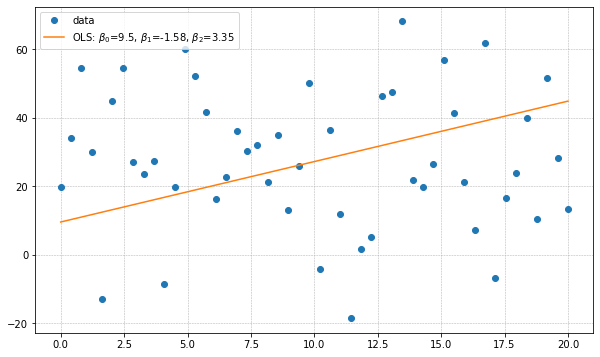

In [5]:
plt.figure(num = 0, figsize = (10, 6))

#this creates a "x axis", with 50 values evenly spaced, from 0 up to 20, useful to see the regression line
x = np.linspace(0, 20, 50) #lower, upper, qty
p = model.params

plt.plot(x, df['y'], 'o',label="data")
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot(x, p.Intercept + p.x1 * x + p.x2 * x, label=r'OLS: $\beta_0$={}, $\beta_1$={}, $\beta_2$={}'.format(round(p.Intercept,2),round(p.x1,2),round(p.x2,2)))
plt.legend(loc='best')

Graphically, our model works just fine.

[]

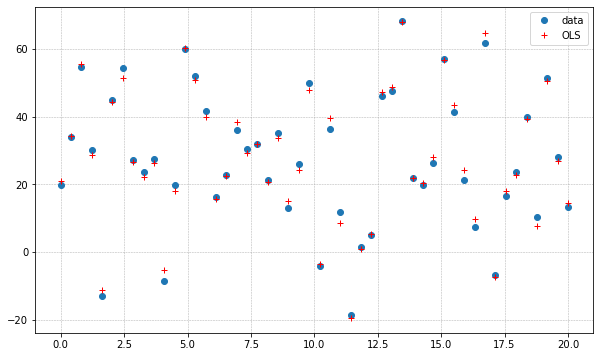

In [6]:
plt.figure(num = 0, figsize = (10, 6))
x = np.linspace(0, 20, 50) #lower, upper, qty

plt.plot(x, df['y'], 'o', label="data")
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot(x, model.fittedvalues, 'r+', label="OLS")
plt.legend(loc='best')
plt.plot()

Now, we will use the Frisch-Waugh-Lovell Theorem in order to get the same coefficients found with the classical OLS regression.
Important: we're forcing $\tilde{x}_{1}$ to be just the **residual** of the regression of $x_{1}$ in $x_{2}$.

In [7]:
#x1_tilde is the part of x1 not explained by x2 (note the .resid)
df['x1_tilde'] = smf.ols('x1 ~ x2', df).fit().resid

#note the '-1' to remove even the constant, thus we're looking exclusively to the effect os x1_tilde over y
smf.ols('y ~ x1_tilde - 1', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
x1_tilde,-1.5842,2.162,-0.733,0.467,-5.929,2.760


<br>
<br>
Note that with $\tilde{x}_{1}$ we've found the same coefficient for $x_{1}$, but with larger std error, and statistically insignificant at .05.
Graphically, we are regressing $x_{1}$ in $x_{2}$, and saving the residuals of it, i.e., the dashed lines below.

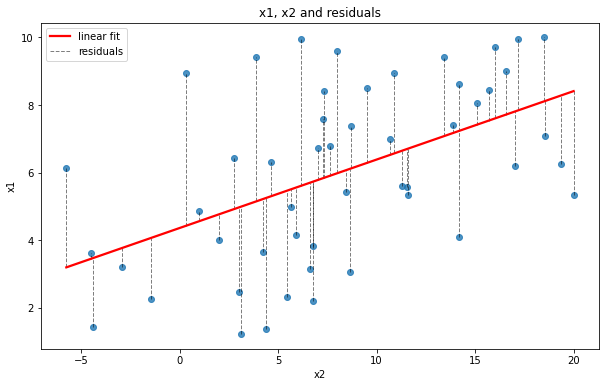

In [8]:
#x1_hat contains the predicted (50) values for the regression of x1 in x2
df['x1_hat'] = smf.ols('x1 ~ x2', df).fit().predict()

plt.figure(num = 0, figsize = (10, 6))

ax = sns.regplot(x="x2", y="x1", data=df, ci=False, line_kws={'color':'r', 'label':'linear fit'})
ax.vlines(df["x2"], 
   np.minimum(df["x1"], df["x1_hat"]), 
   np.maximum(df["x1"], df["x1_hat"]), 
   linestyle='--', color='k', alpha=0.5, linewidth=1, label="residuals")
plt.legend()
plt.title(f"x1, x2 and residuals");

We already have the coefficient, but we want also the same std err and that it be significant. Thus, we regress $y$ on $x_{2}$, and keep just the residuals of it too, in order to get the part of $y$ **not** explained by $x_{2}$.
And then, we regress (with no intercept) $\tilde{y}$ on $\tilde{x}_{1}$, which yields in an estimate for $\beta_{1}$ just like the one obtained with the classical OLS.

In [9]:
#y_tilde is the part of y not explained by x2 (note the .resid)
df['y_tilde'] = smf.ols('y ~ x2', df).fit().resid

#regressing the part of y cleaned from x2 onto the part of x1 cleaned from x2 yields in almost the same std err, and again significant at .05 (almost the same t-statistic also)
smf.ols('y_tilde ~ x1_tilde - 1', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
x1_tilde,-1.5842,0.103,-15.377,0.000,-1.791,-1.377


Notice that std error is now close to the original one, and that the coef is statistically significant. That's the power of the FWL Theorem.